In [1]:
import numpy as np
import os
import struct

In [2]:
def load_mnist(path, kind):
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' %kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' %kind)
   
    with open(labels_path, 'rb') as lb_path:
        magic, n = struct.unpack('>II', lb_path.read(8))
        labels = np.fromfile(lb_path, dtype=np.uint8)
    
    with open(images_path, 'rb') as images_path:
        magic, num, rows, cols = struct.unpack(">IIII", images_path.read(16))
        images = np.fromfile(images_path, dtype=np.uint8).reshape(len(labels), 784)
    return images, labels

In [3]:
X_train, y_train = load_mnist('.\data', 'train')

In [4]:
X_test, y_test = load_mnist('.\data', 't10k')

In [5]:
X_train.shape

(60000, 784)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

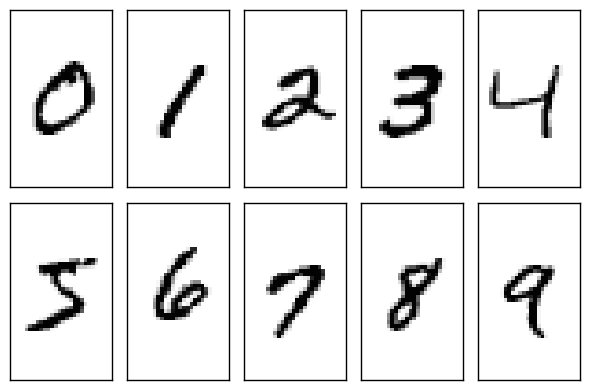

In [7]:
fig, ax = plt.subplots(nrows=2, ncols=5,sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation= 'nearest')
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()

In [8]:
from scipy.special import expit
import sys

In [22]:
class MLP(object):
    def __init__(self, n_output, n_features, n_hidden=30, L1=0.0, L2=0.0, epochs=500, eta=0.0001, alpha=0.0, \
                 decrease_const=0.0, shuffle=True, minibatches=1, random_state=1):
        self.n_output = n_output
        self.n_features = n_features
        self.n_hidden = n_hidden
        self.L1 = L1
        self.L2 = L2
        self.epochs = epochs
        self.eta = eta
        self.alpha = alpha
        self.decrease_const = decrease_const
        self.shuffle = shuffle
        self.minibatches = minibatches
        self.W1, self.W2 = self.__initialize_weights()
        
    def __initialize_weights(self):
        W1 = np.random.uniform(low=-1, high=1, size=self.n_hidden * (self.n_features + 1))
        W1 = W1.reshape((self.n_hidden, self.n_features + 1))
        
        W2 = np.random.uniform(low=-1, high=1, size=self.n_output * (self.n_hidden + 1))
        W2 = W2.reshape((self.n_output, self.n_hidden + 1))
        
        return W1, W2
    
    def __sigmoid(self, z):
        return 1/(1+np.exp(-z))
    
    def __sigmoid_gradient(self, z):
        sg = self.__sigmoid(z)
        return sg * (1-sg)
    
    def __feedforward(self, X, W1, W2):
        N = np.ones((X.shape[0], X.shape[1]+1),dtype=np.int8)
        N[:,1:] = X
        A1 = N
        
        Z2 = W1.dot(A1.T)
        A2 = self.__sigmoid(Z2)
        
        N = np.ones((A2.shape[0]+1, A2.shape[1]),dtype=np.int8)
        N[:-1,:]=A2
        A2 = N
        
        Z3 = W2.dot(A2)
        A3 = self.__sigmoid(Z3)
        
        return Z2, Z3, A1, A2, A3
    
    
    def __l1(self, λ, W1, W2):
        return λ * (np.sum(np.abs(W1[:,1:])) + np.sum(np.abs(W2[:,1:])))
    
    def __l2(self, λ, W1, W2):
        return λ * (np.sum(np.power(W1[:,1:],2)) + np.sum(np.power(W2[:,1:],2)))
    
    def __getcost(self, encoding, output, λ, W1, W2):
        cost = -encoding.dot(np.log(output)) - (1-encoding).dot(np.log(output))
        l1 = self.__l1(λ, W1, W2)
        l2 = self.__l2(λ, W1, W2)
        return cost + l1 + l2
    
    def __back_propagate(self, encoding, A3, A2, A1, Z2, Z3, W1, W2):
        #W1(h,k') and W2(o,h')
        #A1(n,k')
        #Z2(h,n) and A2(h',n)
        #Z3(o,n) and A3(o,n) and encoding(o,n)
        
        N = np.ones((Z3.shape[0] + 1, Z3.shape[0]), dtype=np.int8)
        N[:-1,:] = Z3
        Z3 = N
        
        delta3 = (A3 - encoding) * self.__sigmoid_gradient(Z3)
        grad3 = delta3.dot(A2.T)
        
        N = np.ones((Z2.shape[0] + 1, Z2.shape[0]), dtype=np.int8)
        N[:-1,:] = Z2
        Z2 = N
        
        delta2 = W2.T.dot(delta3) * self.__sigmoid_gradient(Z2)
        grad2 = delta2.dot(A1.T)
    
        return grad2, grad3